# Hand Gesture Detection using Machine Learning

There are multiple way to detect hand gesture without using Machine Learning algorithm such as using color histograms and HOG classifiers, edge detection or background substraction. However, these methods tend to not very robust as it can be affected by the unusual background or changes in lighting conditions.

With a large datasets with different hand gestrues, we can train the model using neural networks. This will somewhat better than the methods mentioned above, even though it will take sometimes for us to train the model.

## Data Preprocessing

I found a dataset of hand gestures on [Kaggle](https://www.kaggle.com/gti-upm/leapgestrecog). This dataset contains 10 different gestures from 10 different people. For each gestures of each person, there will be 200 images of them.

The database structure will look like this:
```
.
+-- 00
|   +-- 01_palm
|       +-- frame_00_01_0001.png
|       +-- frame_00_01_0002.png
|       +-- ....
|   +-- 02_l
|       +-- frame_00_02_0001.png
|       +-- frame_00_02_0002.png
|       +-- ....
....
|   +-- 09_c
|       +-- frame_00_09_0001.png
|       +-- frame_00_09_0002.png
|       +-- ....
|   +-- 010_down
|       +-- frame_00_10_0001.png
|       +-- frame_00_10_0002.png
|       +-- ....
+-- 01
...
+-- 10
```

Let's start by importing all the package that we need

In [31]:
# Import libraries and modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import pandas as pd

from PIL import Image
import numpy as np
import glob
import os

# For reproducibility
np.random.seed(42)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
 
%matplotlib inline
style.use('seaborn-whitegrid')

We are going to get into each person folder, and process all the images for each gestures.

Sadly, my computer is too weak to process everything. I am going to train only on 5 gestures. For each person, I am going to get only 100 images for each gesture.

For each image, I am going to resize them to 200 x 200, and make it becomes grey. In my opinion, changing the color of the image to grey will not affect our overal performance. In addition, having grey color images will help us to train our model much faster.

We also need to convert the image to an array, as our neural network only takes in numbers, not images. Make sure that type of our array to be **float32** so that the neural network can work smoothly. Moreover, we also need to make sure that the number in an array is within (0,1). The reason for all of this can be found [here](https://datascience.stackexchange.com/questions/13636/neural-network-data-type-conversion-float-from-int) and [here](https://stackoverflow.com/questions/4674623/why-do-we-have-to-normalize-the-input-for-an-artificial-neural-network).

In [2]:
# Get the name of all outer folder such as 00, 01, ..., 10
folder_name1 = [name for name in os.listdir(".") 
                if os.path.isdir(name) 
                and name.startswith("0")]

# Get the name of all inner folder such as 01_palm, 02_l, ..., 10_down
folder_name2 = os.listdir("./00")

In [3]:
X = []
y = []

for folder1 in folder_name1:
    # only get 5 gestures :(
    for folder2 in folder_name2[0:5]:
        files = glob.glob(folder1 + "/" + folder2 + "/" + "*.png")
        # only get 100 images
        for file in files[0:100]:
            # converting image to grey scale
            img = Image.open(file).convert('L')
            # resize image to 200 * 200
            img = img.resize((200, 200))
            # converting image to an array
            img = np.asarray(img)
            # make sure that the array is float
            img = np.array(img, dtype = "float32")
            # since all the number is within (0,255), 
            # dividing this to 255 will make the numbers
            # within (0,1)
            img /= 255
            # you do not need to do this step, I just want
            # to reverse the color (eg: black to white)
            img = 1 -img
            
            X.append(img)
            
            label = folder2.split("_",1)[1]
            y.append(label)
    
X = np.array(X)
y = np.array(y)

In [4]:
# list of gesture that we are going to predict
set(y)

{'fist', 'fist_moved', 'l', 'palm', 'thumb'}

In [5]:
# the shape of each of our images
X[0].shape

(200, 200)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42)

In [7]:
# Check shape of full training data.
X_train.shape

(3750, 200, 200)

We need to reshape each image to be 200 x 200 x 1. This allows our neural network to know that there's only one value (how dark the pixel is) instead of multiple values per pixel. For example, a color image stored in RGB (red/green/blue) might have shape 200 x 200 x 3, where one value is corresponds to how red the pixel is, one value corresponds to how blue the pixel is, and one value corresponds to how green the pixel is.

In [8]:
# Reshape each image to be 200 x 200 x 1.
X_train = X_train.reshape(X_train.shape[0], 200, 200, 1)
X_test = X_test.reshape(X_test.shape[0], 200, 200, 1)

In [9]:
X_train.shape

(3750, 200, 200, 1)

We also need to LabelBinarizer our target. This step is very important in classifying. Imagine there is a case where we need to predict class 1 or class 2. Without LabelBinarizer, the neural will understand 1 and 2 as a numerical instead of categorical values

In [10]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

## Model

We are going to use **Convolutional Neural Networks (CNNs)** for this model. CNNs are complex feed forward neural networks that are perfect for image processing as it can condense the image to a smaller size so that the neural networks can run on.

CNNs generally consist of:
- one or more convolutional layers
- one or more pooling layers, and
- one or more fully connected layers

Let's talk briefly about convolutional layers. This is a layers used to detect "things" in images. In those layers, multiple filters are applied. Each filter will create its own layers for the image (eg: 32x32x1 can become 28x28x6). Usually early convolutional layers will detect the edge, later layers detect structures, and the final layers detect the entire objects.

Pooling layers is just another block of CNN. Its main purpose is to reduce the spatial size of the image, which reduces the amount of parameters for the network to train on. Generally, max pooling is used.

Here is the whole network topology for CNNs

Let's start building the model. You can play around with the filters size, kernel size or pooling size. We use ReLU as the activation function because it  can speeding up the training process. The computational step of ReLU is simple as it is only **max(0,input number)**. **Softmax** is also used as we are classifying muliple classes. If you only classify 2 classes, you can use **sigmoid** instead.

In [11]:
# Instantiate a CNN
cnn_model = Sequential()

In [12]:
cnn_model.add(Input(shape = (200,200,1)))

# add a convolutional layer
cnn_model.add(Conv2D(filters = 6,
                     kernel_size = 3,
                     activation = "relu"))

# add a pooling layer
cnn_model.add(MaxPooling2D(pool_size = (3,3)))

# add a convolutional layer
cnn_model.add(Conv2D(kernel_size = 3,
                     filters = 16,
                     activation = "relu"))

# add a pooling layer
cnn_model.add(MaxPooling2D(pool_size = (3,3)))

# add a convolutional layer
cnn_model.add(Conv2D(kernel_size = 3,
                     filters = 26,
                     activation = "relu"))

# add a pooling layer
cnn_model.add(MaxPooling2D(pool_size = (3,3)))

# flatten the 3D array to 1D array
cnn_model.add(Flatten())

# add in first perceptrons
cnn_model.add(Dense(128, activation = "relu"))

# add in second perceptrons
cnn_model.add(Dense(64, activation = "relu"))

# output
cnn_model.add(Dense(len(lb.classes_), activation = "softmax"))

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 6)       60        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 66, 66, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        880       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 26)        3770      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 26)          0         
_________________________________________________________________
flatten (Flatten)            (None, 936)               0

In [13]:
# Compile model
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [14]:
# Fit model on training data
history = cnn_model.fit(X_train,
                        y_train,
                        batch_size=250,
                        validation_data=(X_test, y_test),
                        epochs=5,
                        verbose=1)

W0802 10:05:49.218547 11540 deprecation.py:323] From C:\Users\Minh\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 3750 samples, validate on 1250 samples
Epoch 1/5
3750/3750 [==============================] - 27s 7ms/sample - loss: 1.5284 - accuracy: 0.5336 - val_loss: 1.3553 - val_accuracy: 0.6784
Epoch 2/5
3750/3750 [==============================] - 24s 6ms/sample - loss: 1.0569 - accuracy: 0.7360 - val_loss: 0.6921 - val_accuracy: 0.8088
Epoch 3/5
3750/3750 [==============================] - 23s 6ms/sample - loss: 0.5634 - accuracy: 0.8019 - val_loss: 0.3798 - val_accuracy: 0.8728
Epoch 4/5
3750/3750 [==============================] - 25s 7ms/sample - loss: 0.3088 - accuracy: 0.8875 - val_loss: 0.2085 - val_accuracy: 0.9352
Epoch 5/5
3750/3750 [==============================] - 25s 7ms/sample - loss: 0.2041 - accuracy: 0.9288 - val_loss: 0.1406 - val_accuracy: 0.9576


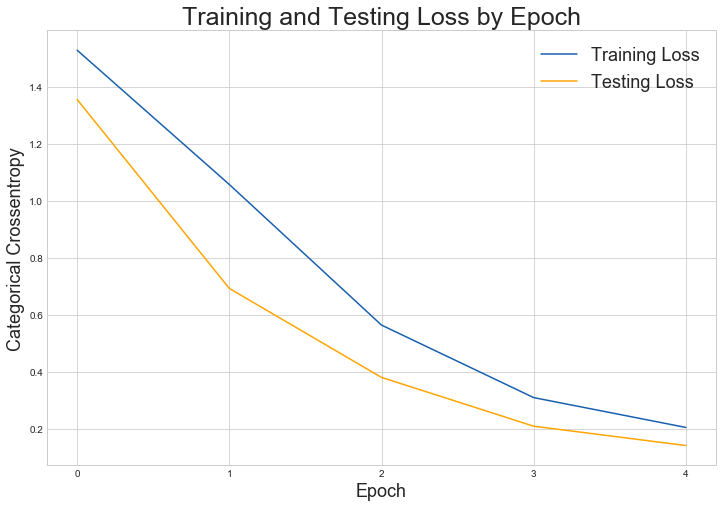

In [15]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4])

plt.legend(fontsize = 18);

As we can see, both the testing and training loss is getting lower and lower. We can try to run the fitting process 1 more time to get a better result.

Let's check how accurate our prediction is:

In [28]:
np.set_printoptions(suppress=True)
labels = {x : y for x,y in enumerate(lb.classes_)}
predict_0 = np.argmax(cnn_model.predict(np.array([X_test[0]])))
labels[predict_0]

'palm'

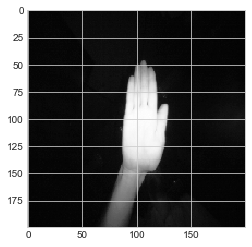

In [20]:
plt.imshow(X_test[0].reshape(200, 200))

Let's look at the confusion matrix.

In [23]:
y_pred = [np.argmax(i) for i in cnn_model.predict(X_test)]

In [24]:
y_pred = [labels[i] for i in y_pred]

In [32]:
from sklearn.metrics import confusion_matrix
con_matrix = confusion_matrix(lb.inverse_transform(y_test), y_pred)
pd.DataFrame(con_matrix, columns = lb.classes_, index = lb.classes_)

,fist,fist_moved,l,palm,thumb
fist,237,7,0,0,14
fist_moved,21,210,0,1,0
l,1,2,270,1,0
palm,0,2,2,242,0
thumb,2,0,0,0,238


It is not a surprised when we have some bad predictions between fist and fist_moved. There are also some confusion on the fist and the thumb

## Capture and predict the gesture through camera

The code below allows you to predict your hand gesture through your own camera. However, unfortunately, this datasets is not suitable for predicting gesture in regular lighting since most of them are captured in the dark. I have tried to adjust the lighting, flip or rotate; but it still does not work. You can try to create you dataset and try.

In [ ]:
import cv2

In [ ]:
cap = cv2.VideoCapture(0)

while (True):
    ret, frame = cap.read()
    cv2.imshow("frame",frame)
 
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Capture the image by pressing q
    if cv2.waitKey(1) & 0xFF == ord("q"):
        
        # Show the captured image
        cv2.imshow("frame2",gray)
        
        # Resize the capture image by transforming it
        # the same way with our dataset
        frame_new = cv2.resize(gray, (200, 200))
        frame_new = np.array(frame_new, dtype = "float32")
        frame_new /= 255
        frame_new = 1 - frame_new
        frame_new = frame_new.reshape(1, 200, 200, 1)
        
        # Predict the captured image
        result = np.argmax(cnn_model.predict(frame_new))
        print(labels[result])


    # close the video by pressing escape
    key = cv2.waitKey(1)
    if key == 27:
        break
        
cap.release()
cv2.destroyAllWindows()

## Conclusion
Luckily we do not run into any overfit problems. If you have any overfit problems (loss of training dataset decreases while that of testing set increases), you can apply some regularization such as **L1/L2 regularization, dropout or early stopping**

It is a bit unfortunate for me to be unable to run the whole datasets and to test this on my own camera. I will build my own dataset with proper lighting in the future, and run this on the cloud server such as AWS.